In [1]:
#import Pkg; Pkg.add("BenchmarkTools")

In [2]:
using BenchmarkTools

In [3]:
#import Pkg; Pkg.add("CSV")
#Pkg.add("Plots")
#Pkg.add("PyPlot")

In [4]:
using Plots

In [5]:
deg_to_rad(theta) = theta * pi / 180.0

"""
Get the projection coefficient, cos(theta),
for a given surface orientation and sun position

sun_altitude:      sun altitude in degree (angle from horizon), degree
sun_south_azimuth: sun azimuth relative to south, negative at east, degree

surface_angle:     vertical angle of the surface, 0° is horizontal and 90° is vertical, degree
surface_south_azimuth: azimuth of the surface, relative to south, with negative values
                       in the southeast direction and positve values in the southwest

Returns cos_theta such as  I = I_normal * cos_theta
"""
function surface_projection(sun_altitude, sun_south_azimuth,
                            surface_angle, surface_south_azimuth)
      
    beta = deg_to_rad(sun_altitude)
    phi_S = -deg_to_rad(sun_south_azimuth)
    sigma = deg_to_rad(surface_angle)
    phi_C = -deg_to_rad(surface_south_azimuth)
    
    cos_theta = cos(beta)*cos(phi_S - phi_C)*sin(sigma) + cos(sigma)*sin(beta)
    return max(cos_theta, 0.0)
end

surface_projection

In [6]:
using CSV

In [7]:
""" Linear interpolation
"""
function build_interp1d(x, y)
    function interp1d_glob(t)
        idx = searchsortedfirst(x, t)
        if idx <= 1
            return y[1]
        elseif idx == length(x)+1
            return y[end]
        else
            prev = idx-1
            slope = (y[idx] - y[prev])/(x[idx] - x[prev])
            return y[prev] + slope*(t - x[prev])
        end
    end
    return interp1d_glob
end

build_interp1d

In [8]:
path = "./data/Fichiers_Meteo_RT2012/H1a_Trappes.csv"
data = CSV.read(path; header=1);

println(names(data))

Symbol[Symbol("# Htsmd"), :te0, :dirN]


In [9]:
# Define interpolation function for weather data
seconds_values = Array(data[!, 1]) * 60.0*60.0;
Text_values = Array(data[!, 2]);
directSun_values = Array(data[!, 3]);

T_ext = build_interp1d(seconds_values, Text_values)
solar_irrad = build_interp1d(seconds_values, directSun_values)

(::var"#interp1d_glob#3"{Array{Float64,1},Array{Float64,1}}) (generic function with 1 method)

In [10]:
include("SimuThermiqueSolver_src.jl")
using .SimuThermiqueSolver

In [11]:
minute = 60.0
hour = 60.0 * minute
day = 24 * hour

86400.0

In [12]:
m = Model(dt=10minute)

L = 3.0  # house size, meter

air = Material(25e-3, 1.225, 1.0006)
clay = Material(1.28, 880.0, 1450.0) # Clay
roof_isolation = Material(0.036, 150.0, 2700.2)
slab_isolation = Material(0.036, 150.0, 2700.2)
wall_isolation = Material(0.036, 150.0, 2700.2)

interior_air = add_simplethermalmass!(m, "air"; thermal_mass=air.rho*air.Cp*L^2)
roof = add_simple_wall!(m, "roof", material=roof_isolation, thickness=.10, area=1.2*L)
slab = add_composite_wall!(m, "slab", layers=[(slab_isolation, 0.1), (clay, 1.5*L)], area=1.0*L)
south_wall = add_simple_wall!(m, "souht_wall", material=wall_isolation, thickness=0.10, area=L*0.5)

h_exterior = 6.5
h_interior_vertical = .7
h_interior_horizontal = 2.5


add_convectivesource!(m, roof.ext; Tsource=T_ext, hS=h_exterior*L)
add_convectivesource!(m, south_wall.ext; Tsource=T_ext, hS=h_exterior*L)

add_conductance!(m, roof.int, interior_air; UA=h_interior_vertical*L/2)
add_conductance!(m, south_wall.int, interior_air; UA=h_interior_vertical*L/2)
add_conductance!(m, slab.int, interior_air; UA=h_interior_horizontal*L)

add_convectivesource!(m, slab.ext; Tsource=t->14, hS=10*h_exterior)

add_directsource!(m, roof.ext, flux=t->0.8*solar_irrad(t)*L)
add_directsource!(m, south_wall.ext, flux=t->0.4*solar_irrad(t)*L/2.0)

In [13]:
save = [roof.int, slab.int, interior_air];
save_idx = map(x->m.id_to_index[x], save);

In [27]:
state = init_solver(m);

# Burn (solve in reverse)
state.dt = -state.dt
state.t = 50day

n_iter = Int(floor(state.t/m.dt));

for k in 1:n_iter
    iter!(state)
end

state.dt = -state.dt

600.0

In [28]:
# solve
n_iter = Int(floor(150day/m.dt));

sol = zeros(n_iter, length(m.M))
times = zeros(n_iter)
for k in 1:n_iter
    iter!(state)
    sol[k, :] = state.T
    times[k] = state.t
end

In [29]:
function groupby_day(y, nbr_values_per_day)
    y = reshape(y, (:, nbr_values_per_day));

    y_max = maximum.(eachcol(y))
    y_min = minimum.(eachcol(y))
    y_avg = mean.(eachcol(y))
    return y_min, y_avg, y_max
end

groupby_day (generic function with 1 method)

In [30]:
#plot(times/hour, sol, label=permutedims(save))
#plot!(times/hour, [T_ext(t) for t in times], label="T_ext")
#plot!(times/hour, [0.01*solar_irrad(t) for t in times], label="solar")

MetaModel

same as model but takes Params instead of values

In [31]:
dt = m.dt
nbr_values_per_day = Int( day / dt )

t_min, t_avg, t_max = groupby_day(times, nbr_values_per_day)

([600.0, 90600.0, 180600.0, 270600.0, 360600.0, 450600.0, 540600.0, 630600.0, 720600.0, 810600.0  …  1.20606e7, 1.21506e7, 1.22406e7, 1.23306e7, 1.24206e7, 1.25106e7, 1.26006e7, 1.26906e7, 1.27806e7, 1.28706e7], [45300.0, 135300.0, 225300.0, 315300.0, 405300.0, 495300.0, 585300.0, 675300.0, 765300.0, 855300.0  …  1.21053e7, 1.21953e7, 1.22853e7, 1.23753e7, 1.24653e7, 1.25553e7, 1.26453e7, 1.27353e7, 1.28253e7, 1.29153e7], [90000.0, 180000.0, 270000.0, 360000.0, 450000.0, 540000.0, 630000.0, 720000.0, 810000.0, 900000.0  …  1.215e7, 1.224e7, 1.233e7, 1.242e7, 1.251e7, 1.26e7, 1.269e7, 1.278e7, 1.287e7, 1.296e7])

In [25]:
m.id_to_index

Dict{String,Int64} with 9 entries:
  "roof_ext"       => 2
  "slab2_int"      => 218
  "slab1_ext"      => 18
  "souht_wall_ext" => 220
  "slab2_ext"      => 33
  "slab1_int"      => 33
  "souht_wall_int" => 235
  "air"            => 1
  "roof_int"       => 17

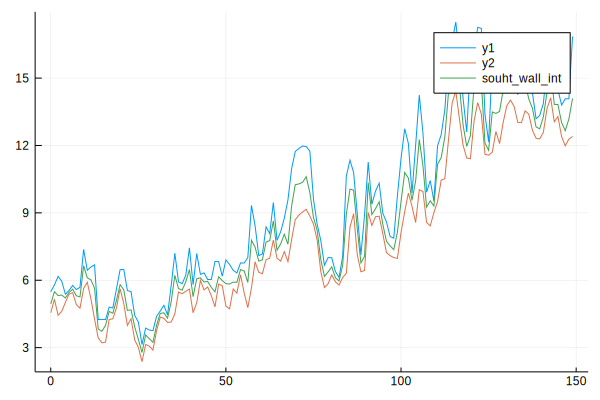

In [35]:
node_name = "souht_wall_int"
idx = m.id_to_index[node_name]

y_min, y_avg, y_max = groupby_day(sol[:, idx], nbr_values_per_day)

plot( t_min/day, y_max)
plot!(t_min/day, y_min)
plot!(t_min/day, y_avg, label=node_name)